# Futures Price Rolling: Building Continuous Price Series

## Overview

Futures contracts have expiration dates, which creates a challenge when building long-term price series for analysis. When we move from one contract to the next (e.g., from the February contract to the March contract), there's typically a price gap between them. This gap reflects factors like:
- Cost of carry (storage, financing)
- Convenience yield
- Market expectations

**Rolling** (or "stitching") futures contracts creates a continuous price series by adjusting for these gaps.

---

## Roll Methodology: `R:02_0_D`

The naming convention `R:02_0_D` in our data indicates:
- **02**: Roll occurs 2 business days before contract expiry/roll date
- **0**: Adjustment method index (backward Panama adjustment)
- **D**: Daily frequency

---

## Adjustment Methods

### 1. Backward Adjustment (Panama Method) - Used Here
- Adjusts **all historical prices** when a roll occurs
- The most recent prices remain unchanged
- Historical prices are shifted by the gap amount
- **Pros**: Current prices match actual market prices
- **Cons**: Historical prices can become negative for commodities in contango

### 2. Forward Adjustment
- Adjusts **all future prices** when a roll occurs
- Historical prices remain unchanged
- **Pros**: Historical prices match what was actually traded
- **Cons**: Current prices don't match the market

### 3. Ratio Adjustment
- Uses multiplicative adjustments instead of additive
- Prevents negative prices
- Better for computing returns

---

## Expected Input Format

The input DataFrame should contain:

| Column | Description | Example |
|--------|-------------|----------|
| `index` | Date index (datetime) | 2010-01-04 |
| `CL1` | Front month (nearest) contract price | 81.51 |
| `CL2` | Second month contract price | 82.12 |
| `CL3` | Third month contract price | 82.65 |
| ... | Additional contract months (optional) | ... |

**Notes:**
- Column names should follow the pattern `{SYMBOL}{N}` where N is the contract month (1=front, 2=second, etc.)
- Data should be sorted by date in ascending order
- Missing values (NaN) are acceptable and will be handled

---

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Literal, Optional, Tuple
from dataclasses import dataclass

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Load the data
df = pd.read_csv('wti_price_cot.csv', index_col=0, parse_dates=True)

# Display basic info
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns:")
for col in df.columns:
    print(f"  - {col}")

Data shape: (3933, 12)
Date range: 2010-01-04 00:00:00 to 2025-08-05 00:00:00

Columns:
  - CL1
  - CL2
  - CL3
  - CL1 R:02_0_D
  - CL2 R:02_0_D
  - CL3 R:02_0_D
  - .WTICOMN
  - .WTICOML
  - .WTICOMS
  - .WTIMMN
  - .WTIMML
  - .WTIMMS


In [3]:
# Preview the data
df.head(10)

,CL1,CL2,CL3,CL1 R:02_0_D,CL2 R:02_0_D,CL3 R:02_0_D,.WTICOMN,.WTICOML,.WTICOMS,.WTIMMN,.WTIMML,.WTIMMS
2010-01-04,81.51,82.12,82.65,104.06,86.72,73.20,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,81.77,82.41,82.99,104.32,87.01,73.54,-304987.0,432717.0,737704.0,205857.0,332739.0,126882.0
2010-01-06,83.18,83.75,84.31,105.73,88.35,74.86,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,82.66,83.19,83.75,105.21,87.79,74.30,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,82.75,83.30,83.87,105.30,87.90,74.42,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,82.52,83.01,83.55,105.07,87.61,74.10,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,80.79,81.17,81.70,103.34,85.77,72.25,-297279.0,451398.0,748677.0,226565.0,351626.0,125061.0
2010-01-13,79.65,80.04,80.60,102.20,84.64,71.15,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-14,79.39,79.88,80.47,101.94,84.48,71.02,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-15,78.00,78.37,78.97,100.55,82.97,69.52,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Extract raw and rolled price columns
raw_cols = ['CL1', 'CL2', 'CL3']
rolled_cols = ['CL1 R:02_0_D', 'CL2 R:02_0_D', 'CL3 R:02_0_D']

# Create separate DataFrames for clarity
raw_prices = df[raw_cols].copy()
target_rolled_prices = df[rolled_cols].copy()

print("Raw prices statistics:")
raw_prices.describe()

Raw prices statistics:


,CL1,CL2,CL3
count,3927.000000,3927.000000,3927.000000
mean,71.815666,71.918004,71.919995
std,20.983140,20.559497,20.203297
min,-37.630000,11.570000,18.690000
25%,53.815000,54.165000,54.555000
50%,72.150000,72.100000,71.760000
75%,88.740000,88.845000,88.995000
max,123.700000,119.780000,117.150000


## 2. Visualize Raw vs Rolled Prices

Let's first understand the difference between raw and rolled prices visually.

## Visual Explanation: How Futures Rolling Works

The diagram below illustrates the backward adjustment (Panama) method used in this dataset.

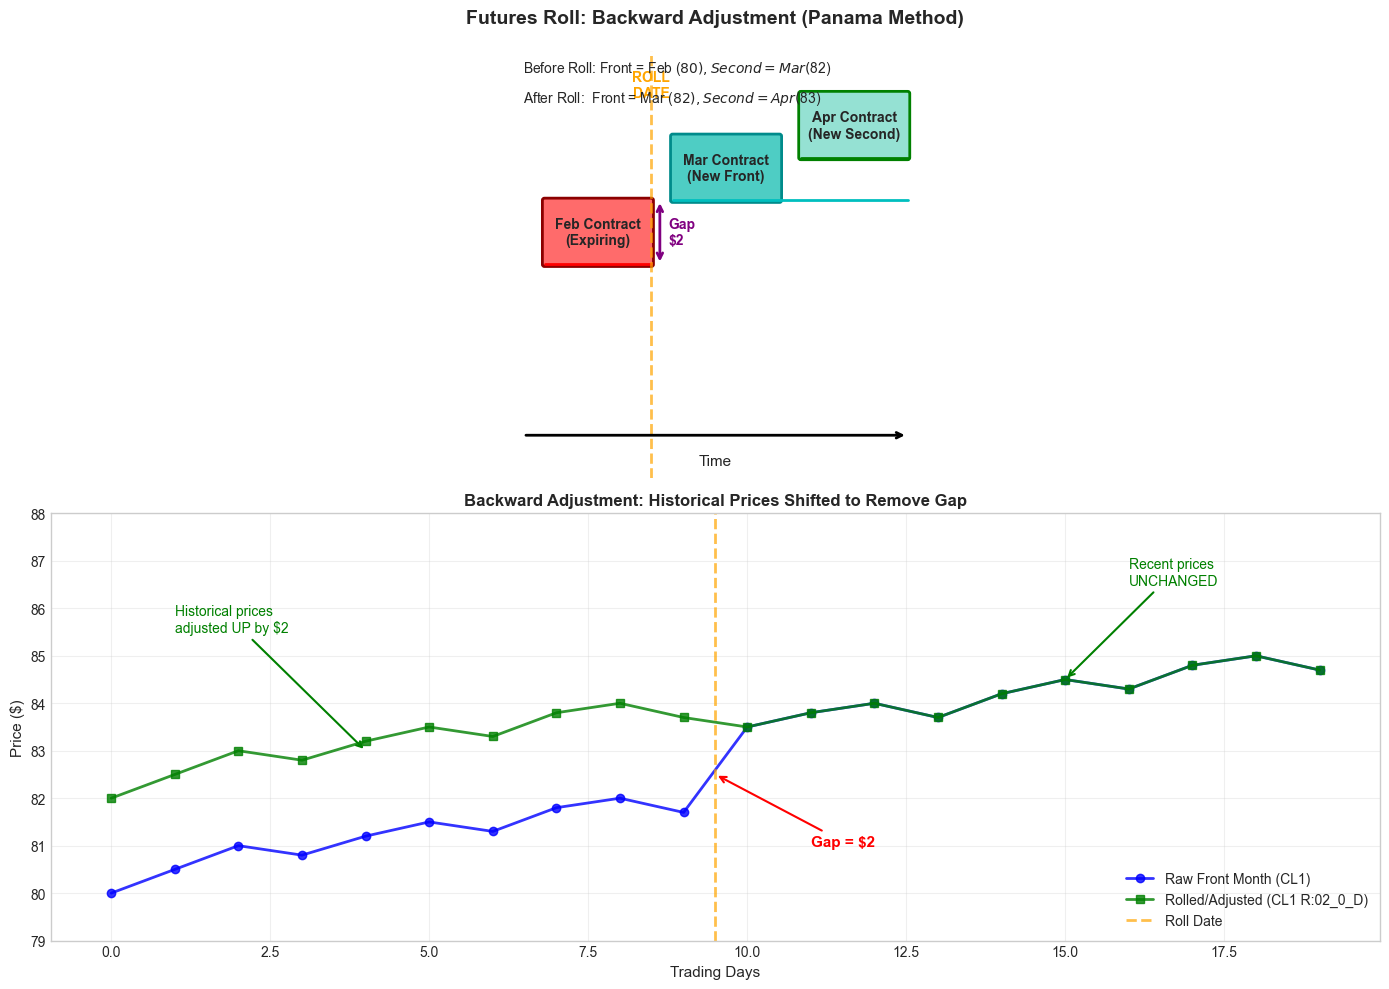


Diagram saved as 'roll_explanation_diagram.png'


In [5]:
# Create a visual diagram explaining the rolling process
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ============================================
# DIAGRAM 1: Conceptual illustration of roll
# ============================================
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('Futures Roll: Backward Adjustment (Panama Method)', fontsize=14, fontweight='bold', pad=20)

# Time axis
ax1.annotate('', xy=(9.5, 1), xytext=(0.5, 1),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax1.text(5, 0.3, 'Time', ha='center', fontsize=11)

# Contract boxes
# February contract (expiring)
feb_box = FancyBboxPatch((1, 5), 2.5, 1.5, boxstyle="round,pad=0.05", 
                          facecolor='#FF6B6B', edgecolor='darkred', linewidth=2)
ax1.add_patch(feb_box)
ax1.text(2.25, 5.75, 'Feb Contract\n(Expiring)', ha='center', va='center', fontsize=10, fontweight='bold')

# March contract (new front)
mar_box = FancyBboxPatch((4, 6.5), 2.5, 1.5, boxstyle="round,pad=0.05",
                          facecolor='#4ECDC4', edgecolor='darkcyan', linewidth=2)
ax1.add_patch(mar_box)
ax1.text(5.25, 7.25, 'Mar Contract\n(New Front)', ha='center', va='center', fontsize=10, fontweight='bold')

# April contract
apr_box = FancyBboxPatch((7, 7.5), 2.5, 1.5, boxstyle="round,pad=0.05",
                          facecolor='#95E1D3', edgecolor='green', linewidth=2)
ax1.add_patch(apr_box)
ax1.text(8.25, 8.25, 'Apr Contract\n(New Second)', ha='center', va='center', fontsize=10, fontweight='bold')

# Price levels
ax1.plot([1, 3.5], [5, 5], 'r-', lw=2, label='Feb price: $80')
ax1.plot([4, 9.5], [6.5, 6.5], 'c-', lw=2, label='Mar price: $82')
ax1.plot([7, 9.5], [7.5, 7.5], 'g-', lw=2, label='Apr price: $83')

# Gap annotation
ax1.annotate('', xy=(3.7, 6.5), xytext=(3.7, 5),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax1.text(3.9, 5.75, 'Gap\n$2', ha='left', va='center', fontsize=10, color='purple', fontweight='bold')

# Roll date marker
ax1.axvline(x=3.5, color='orange', linestyle='--', lw=2, alpha=0.7)
ax1.text(3.5, 9.2, 'ROLL\nDATE', ha='center', va='center', fontsize=10, color='orange', fontweight='bold')

# Legend
ax1.text(0.5, 9.5, 'Before Roll: Front = Feb ($80), Second = Mar ($82)', fontsize=10)
ax1.text(0.5, 8.8, 'After Roll:  Front = Mar ($82), Second = Apr ($83)', fontsize=10)

# ============================================
# DIAGRAM 2: Price series before/after adjustment
# ============================================
ax2 = axes[1]

# Create sample data
dates = np.arange(20)
# Raw prices - shows the gap at roll
raw_contract1 = np.array([80, 80.5, 81, 80.8, 81.2, 81.5, 81.3, 81.8, 82, 81.7,  # Feb contract
                          np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
raw_contract2 = np.array([82, 82.3, 82.5, 82.2, 82.8, 83, 82.7, 83.2, 83.5, 83.3,  # Mar as second
                          83.5, 83.8, 84, 83.7, 84.2, 84.5, 84.3, 84.8, 85, 84.7])  # Mar as front

# Front month series (jumps at roll)
front_raw = np.concatenate([raw_contract1[:10], raw_contract2[10:]])
front_raw[10] = 83.5  # Gap!

# Rolled series (smooth)
gap = 2  # $2 gap
rolled = front_raw.copy()
rolled[:10] = rolled[:10] + gap  # Add gap to historical prices

ax2.plot(dates, front_raw, 'b-o', lw=2, markersize=6, label='Raw Front Month (CL1)', alpha=0.8)
ax2.plot(dates, rolled, 'g-s', lw=2, markersize=6, label='Rolled/Adjusted (CL1 R:02_0_D)', alpha=0.8)

# Highlight the gap
ax2.axvline(x=9.5, color='orange', linestyle='--', lw=2, alpha=0.7, label='Roll Date')
ax2.annotate('Gap = $2', xy=(9.5, 82.5), xytext=(11, 81),
            fontsize=11, color='red', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

# Annotations
ax2.annotate('Historical prices\nadjusted UP by $2', xy=(4, 83), xytext=(1, 85.5),
            fontsize=10, color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

ax2.annotate('Recent prices\nUNCHANGED', xy=(15, 84.5), xytext=(16, 86.5),
            fontsize=10, color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

ax2.set_xlabel('Trading Days', fontsize=11)
ax2.set_ylabel('Price ($)', fontsize=11)
ax2.set_title('Backward Adjustment: Historical Prices Shifted to Remove Gap', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(79, 88)

plt.tight_layout()
plt.savefig('roll_explanation_diagram.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nDiagram saved as 'roll_explanation_diagram.png'")

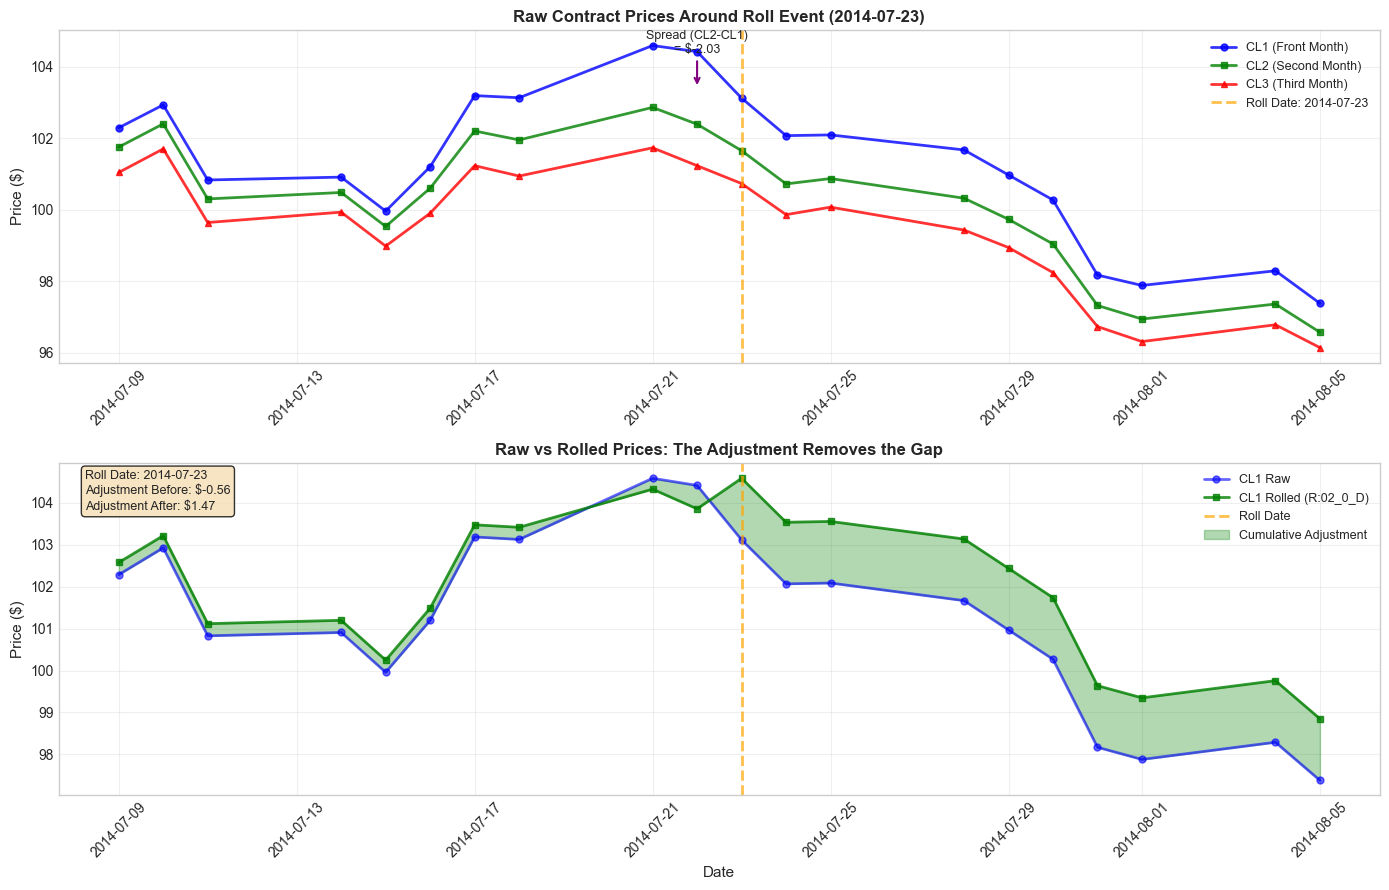


Diagram showing actual roll event on 2014-07-23 saved as 'roll_actual_data_diagram.png'


In [6]:
# Create a diagram using ACTUAL data from the CSV showing a real roll event
fig, axes = plt.subplots(2, 1, figsize=(14, 9))

# Find a clear roll event in the data (look for a significant adjustment change)
target_adj = df['CL1 R:02_0_D'] - df['CL1']
adj_change = target_adj.diff()

# Find a date with a significant roll (gap > $1)
significant_rolls = adj_change[adj_change.abs() > 1].dropna()
if len(significant_rolls) > 0:
    roll_date = significant_rolls.index[5]  # Pick the 6th significant roll for variety
else:
    roll_date = df.index[100]

# Get a window around the roll
start_idx = max(0, df.index.get_loc(roll_date) - 10)
end_idx = min(len(df), df.index.get_loc(roll_date) + 10)
window = df.iloc[start_idx:end_idx]

# ============================================
# PLOT 1: Raw prices showing the contracts
# ============================================
ax1 = axes[0]
ax1.plot(window.index, window['CL1'], 'b-o', lw=2, markersize=5, label='CL1 (Front Month)', alpha=0.8)
ax1.plot(window.index, window['CL2'], 'g-s', lw=2, markersize=5, label='CL2 (Second Month)', alpha=0.8)
ax1.plot(window.index, window['CL3'], 'r-^', lw=2, markersize=5, label='CL3 (Third Month)', alpha=0.8)

ax1.axvline(x=roll_date, color='orange', linestyle='--', lw=2, alpha=0.7, label=f'Roll Date: {roll_date.strftime("%Y-%m-%d")}')
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.set_title(f'Raw Contract Prices Around Roll Event ({roll_date.strftime("%Y-%m-%d")})', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add spread annotation
roll_idx = df.index.get_loc(roll_date)
if roll_idx > 0:
    prev_date = df.index[roll_idx - 1]
    spread = df.loc[prev_date, 'CL2'] - df.loc[prev_date, 'CL1']
    ax1.annotate(f'Spread (CL2-CL1)\n= ${spread:.2f}', 
                xy=(prev_date, (df.loc[prev_date, 'CL1'] + df.loc[prev_date, 'CL2'])/2),
                xytext=(prev_date, df.loc[prev_date, 'CL2'] + 2),
                fontsize=9, ha='center',
                arrowprops=dict(arrowstyle='->', color='purple', lw=1.5))

# ============================================
# PLOT 2: Raw vs Rolled comparison
# ============================================
ax2 = axes[1]
ax2.plot(window.index, window['CL1'], 'b-o', lw=2, markersize=5, label='CL1 Raw', alpha=0.6)
ax2.plot(window.index, window['CL1 R:02_0_D'], 'g-s', lw=2, markersize=5, label='CL1 Rolled (R:02_0_D)', alpha=0.8)

ax2.axvline(x=roll_date, color='orange', linestyle='--', lw=2, alpha=0.7, label='Roll Date')

# Show the adjustment
adj_before = target_adj.loc[:roll_date].iloc[-2] if roll_date in target_adj.index else 0
adj_after = target_adj.loc[roll_date:].iloc[0] if roll_date in target_adj.index else 0

ax2.fill_between(window.index, window['CL1'], window['CL1 R:02_0_D'], 
                  alpha=0.3, color='green', label='Cumulative Adjustment')

ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Price ($)', fontsize=11)
ax2.set_title('Raw vs Rolled Prices: The Adjustment Removes the Gap', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Add text box with key info
textstr = f'Roll Date: {roll_date.strftime("%Y-%m-%d")}\nAdjustment Before: ${adj_before:.2f}\nAdjustment After: ${adj_after:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('roll_actual_data_diagram.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nDiagram showing actual roll event on {roll_date.strftime('%Y-%m-%d')} saved as 'roll_actual_data_diagram.png'")

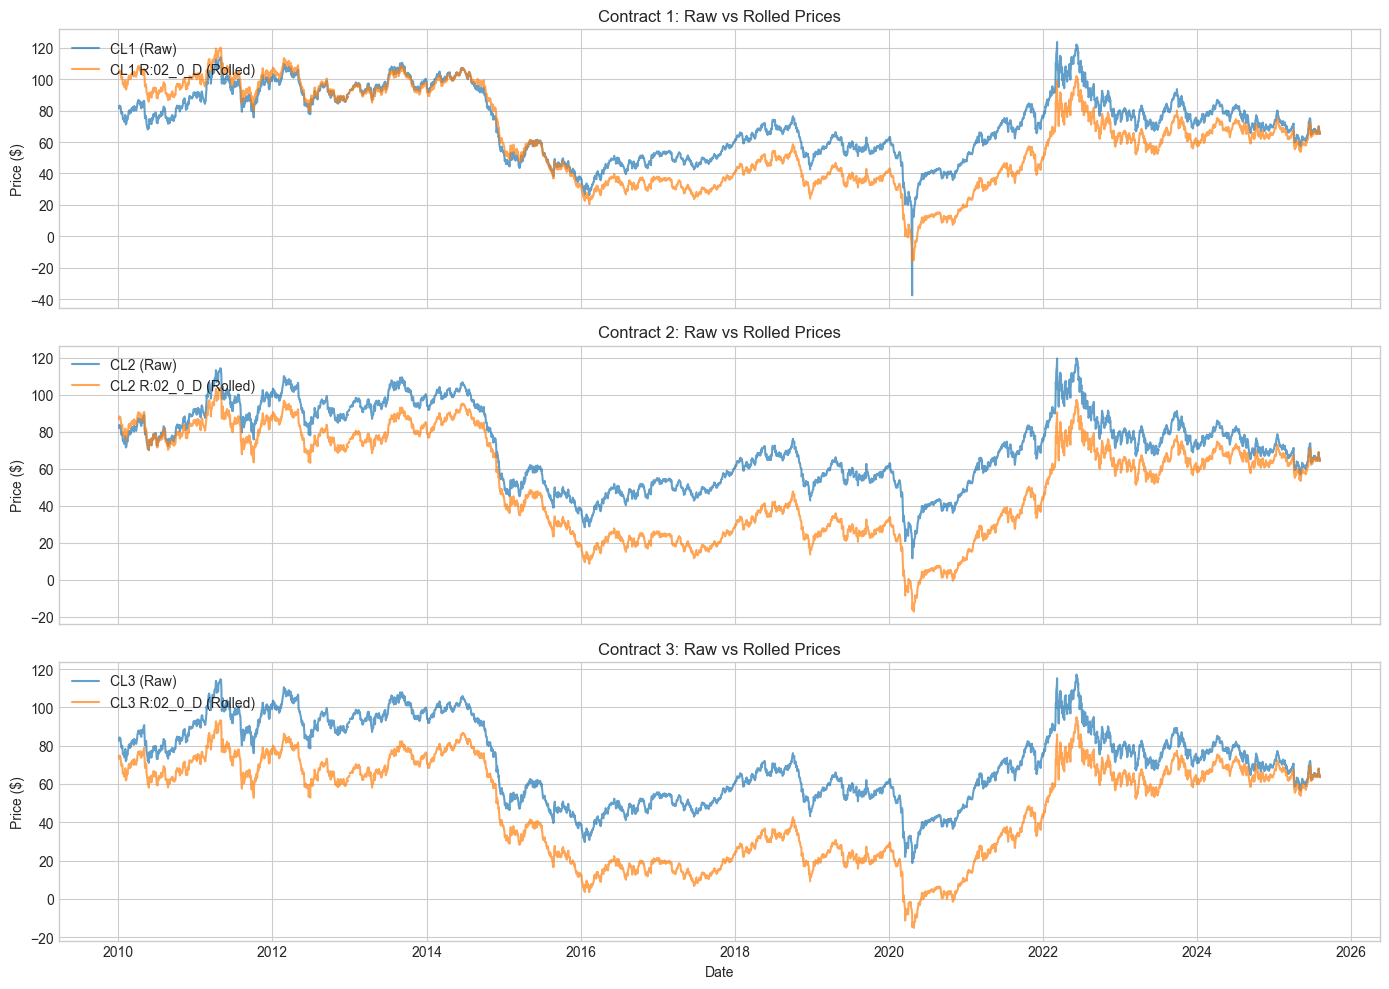

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, (raw_col, rolled_col) in enumerate(zip(raw_cols, rolled_cols)):
    ax = axes[i]
    ax.plot(df.index, df[raw_col], label=f'{raw_col} (Raw)', alpha=0.7)
    ax.plot(df.index, df[rolled_col], label=f'{rolled_col} (Rolled)', alpha=0.7)
    ax.set_ylabel('Price ($)')
    ax.legend(loc='upper left')
    ax.set_title(f'Contract {i+1}: Raw vs Rolled Prices')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

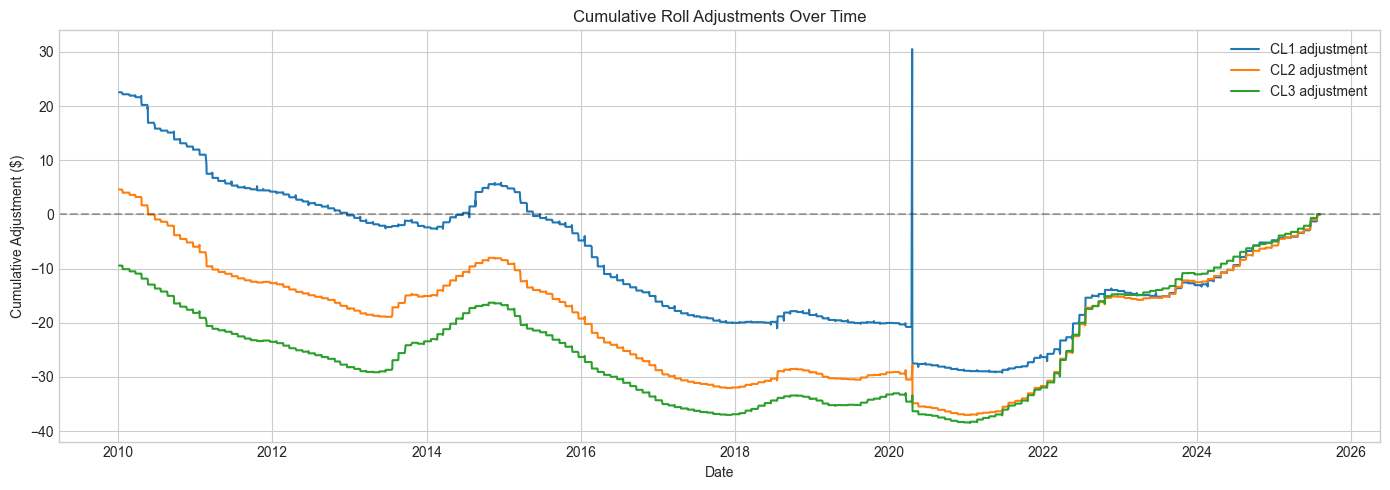

In [8]:
# Plot the cumulative adjustment (difference between rolled and raw)
fig, ax = plt.subplots(figsize=(14, 5))

for raw_col, rolled_col in zip(raw_cols, rolled_cols):
    adjustment = df[rolled_col] - df[raw_col]
    ax.plot(df.index, adjustment, label=f'{raw_col} adjustment')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Adjustment ($)')
ax.set_title('Cumulative Roll Adjustments Over Time')
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 3. FuturesRoller Class

A modular, reusable class for rolling futures prices.

### Class Design

```
FuturesRoller
├── __init__(roll_days_before, adjustment_method, detection_method)
├── detect_roll_dates(prices_df) → List[datetime]
├── compute_adjustments(prices_df, roll_dates) → Series
├── apply_adjustments(prices_df, adjustments) → DataFrame
└── roll(prices_df) → DataFrame  # Main entry point
```

### Parameters

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| `roll_days_before` | int | 2 | Days before the detected roll to execute the roll |
| `adjustment_method` | str | 'backward' | 'backward', 'forward', or 'ratio' |
| `detection_method` | str | 'price_gap' | Method to detect roll dates |
| `gap_threshold` | float | 0.5 | Minimum price gap to consider as a roll |

---

In [9]:
@dataclass
class RollEvent:
    """Represents a single roll event."""
    date: pd.Timestamp
    gap: float  # Price gap at roll (new contract - old contract)
    from_price: float  # Price of expiring contract
    to_price: float  # Price of new front contract


class FuturesRoller:
    """
    A modular class for creating continuous futures price series.
    
    This class handles the detection of roll dates and applies adjustments
    to create a continuous price series from individual futures contracts.
    
    Parameters
    ----------
    roll_days_before : int, default=2
        Number of business days before the detected roll date to execute the roll.
        For example, if roll_days_before=2 and a contract change is detected on
        day T, the roll adjustment is applied on day T-2.
    
    adjustment_method : {'backward', 'forward', 'ratio'}, default='backward'
        Method used to adjust prices:
        - 'backward': Adjust all historical prices (Panama method)
        - 'forward': Adjust all future prices
        - 'ratio': Use multiplicative adjustments
    
    gap_threshold : float, default=0.01
        Minimum absolute price change (as fraction of price) between consecutive
        days to consider as a potential roll. Helps filter out normal volatility.
    
    Attributes
    ----------
    roll_events_ : List[RollEvent]
        List of detected roll events after calling roll()
    
    cumulative_adjustment_ : pd.Series
        Cumulative adjustment applied at each date
    
    Examples
    --------
    >>> roller = FuturesRoller(roll_days_before=2, adjustment_method='backward')
    >>> rolled_prices = roller.roll(raw_prices_df, contract_col='CL1')
    """
    
    def __init__(
        self,
        roll_days_before: int = 2,
        adjustment_method: Literal['backward', 'forward', 'ratio'] = 'backward',
        gap_threshold: float = 0.01
    ):
        self.roll_days_before = roll_days_before
        self.adjustment_method = adjustment_method
        self.gap_threshold = gap_threshold
        
        # Attributes set after rolling
        self.roll_events_: List[RollEvent] = []
        self.cumulative_adjustment_: Optional[pd.Series] = None
    
    def detect_roll_dates(
        self,
        front_prices: pd.Series,
        second_prices: pd.Series
    ) -> List[RollEvent]:
        """
        Detect roll dates by analyzing the spread dynamics between contracts.
        
        Roll detection logic:
        - A roll occurs when the spread (F2 - F1) changes sign or magnitude significantly
        - This happens because F1 switches from one contract month to the next
        - After a roll, the new F1 ≈ old F2 (same contract month)
        
        Parameters
        ----------
        front_prices : pd.Series
            Prices of the front month contract (e.g., CL1)
        second_prices : pd.Series
            Prices of the second month contract (e.g., CL2)
        
        Returns
        -------
        List[RollEvent]
            List of detected roll events with dates and gap sizes
        """
        roll_events = []
        
        # Compute the spread between F2 and F1
        spread = second_prices - front_prices
        spread_change = spread.diff()
        
        # Compute daily price changes
        front_change = front_prices.diff()
        second_change = second_prices.diff()
        
        for i in range(1, len(front_prices)):
            date = front_prices.index[i]
            
            curr_front = front_prices.iloc[i]
            prev_front = front_prices.iloc[i-1]
            prev_second = second_prices.iloc[i-1]
            curr_spread = spread.iloc[i]
            prev_spread = spread.iloc[i-1]
            
            if pd.isna(curr_front) or pd.isna(prev_front) or pd.isna(prev_second):
                continue
            if pd.isna(curr_spread) or pd.isna(prev_spread):
                continue
                
            # The gap at roll is the previous day's spread (F2 - F1)
            gap = prev_spread
            
            # Roll detection criteria:
            # 1. The spread collapses (becomes much smaller) because new F1 = old F2's contract
            # 2. The front contract jumps by approximately the spread amount
            
            spread_collapsed = abs(curr_spread) < abs(prev_spread) * 0.5
            spread_was_significant = abs(prev_spread) > 0.10  # At least 10 cents
            
            # Check if F1 jumped toward F2
            front_jumped = abs(curr_front - prev_second) < abs(prev_spread) * 0.5
            
            # Alternative: detect when spread changes sign or drops sharply
            spread_sign_change = (prev_spread > 0.1 and curr_spread < 0.1) or \
                                 (prev_spread < -0.1 and curr_spread > -0.1)
            
            if spread_was_significant and (spread_collapsed or front_jumped or spread_sign_change):
                # Verify by checking if the price move is abnormal
                normal_move = abs(second_change.iloc[i]) if not pd.isna(second_change.iloc[i]) else 0
                actual_move = abs(front_change.iloc[i]) if not pd.isna(front_change.iloc[i]) else 0
                
                # If front moved much more than second, it's likely a roll
                if actual_move > normal_move + abs(gap) * 0.3:
                    roll_events.append(RollEvent(
                        date=date,
                        gap=gap,
                        from_price=prev_front,
                        to_price=curr_front
                    ))
        
        return roll_events
    
    def detect_roll_dates_from_spread(
        self,
        front_prices: pd.Series,
        second_prices: pd.Series,
        third_prices: pd.Series
    ) -> List[RollEvent]:
        """
        Alternative roll detection using spread between F2-F1 and F3-F2.
        
        When a roll occurs:
        - Old F1 expires, old F2 becomes new F1, old F3 becomes new F2
        - So: new (F2-F1) should equal old (F3-F2)
        
        This is more robust than single-contract analysis.
        """
        roll_events = []
        
        spread_12 = second_prices - front_prices  # F2 - F1
        spread_23 = third_prices - second_prices   # F3 - F2
        
        for i in range(1, len(front_prices)):
            date = front_prices.index[i]
            
            curr_spread_12 = spread_12.iloc[i]
            prev_spread_12 = spread_12.iloc[i-1]
            prev_spread_23 = spread_23.iloc[i-1]
            
            if pd.isna(curr_spread_12) or pd.isna(prev_spread_12) or pd.isna(prev_spread_23):
                continue
            
            # After a roll: new spread_12 ≈ old spread_23
            # Check if today's spread_12 is closer to yesterday's spread_23 than to yesterday's spread_12
            diff_to_prev_12 = abs(curr_spread_12 - prev_spread_12)
            diff_to_prev_23 = abs(curr_spread_12 - prev_spread_23)
            
            spread_shifted = diff_to_prev_23 < diff_to_prev_12 * 0.5
            spread_was_different = abs(prev_spread_12 - prev_spread_23) > 0.05
            
            if spread_shifted and spread_was_different and abs(prev_spread_12) > 0.05:
                roll_events.append(RollEvent(
                    date=date,
                    gap=prev_spread_12,
                    from_price=front_prices.iloc[i-1],
                    to_price=front_prices.iloc[i]
                ))
        
        return roll_events
    
    def compute_backward_adjustments(
        self,
        prices: pd.Series,
        roll_events: List[RollEvent]
    ) -> pd.Series:
        """
        Compute cumulative backward adjustments (Panama method).
        
        For backward adjustment, we accumulate all future roll gaps
        and add them to historical prices. The most recent prices
        remain unchanged (adjustment = 0).
        
        Parameters
        ----------
        prices : pd.Series
            Original price series
        roll_events : List[RollEvent]
            Detected roll events
        
        Returns
        -------
        pd.Series
            Cumulative adjustment to add to each price
        """
        # Initialize adjustment series with zeros
        adjustments = pd.Series(0.0, index=prices.index)
        
        # Sort roll events by date (oldest first)
        sorted_events = sorted(roll_events, key=lambda x: x.date)
        
        # For backward adjustment: accumulate gaps from the end
        # Most recent prices have 0 adjustment
        # Earlier prices have sum of all subsequent gaps
        
        cumulative_gap = 0.0
        # Process from most recent to oldest
        for event in reversed(sorted_events):
            cumulative_gap += event.gap
            
            # Find the adjustment date (roll_days_before the roll)
            try:
                roll_idx = prices.index.get_loc(event.date)
                adjusted_idx = max(0, roll_idx - self.roll_days_before)
                adjust_date = prices.index[adjusted_idx]
                
                # All dates BEFORE this roll get this cumulative adjustment
                mask = prices.index < adjust_date
                adjustments.loc[mask] = cumulative_gap
            except KeyError:
                continue
        
        return adjustments
    
    def compute_ratio_adjustments(
        self,
        prices: pd.Series,
        roll_events: List[RollEvent]
    ) -> pd.Series:
        """
        Compute cumulative ratio adjustments.
        
        For ratio adjustment, we multiply historical prices by the
        cumulative ratio of price levels at each roll.
        
        Returns
        -------
        pd.Series
            Multiplicative adjustment factor for each price
        """
        # Initialize with ones (no adjustment)
        adjustments = pd.Series(1.0, index=prices.index)
        
        sorted_events = sorted(roll_events, key=lambda x: x.date, reverse=True)
        
        cumulative_ratio = 1.0
        for event in sorted_events:
            if event.from_price != 0:
                ratio = event.to_price / event.from_price
                cumulative_ratio *= ratio
                
                roll_idx = prices.index.get_loc(event.date)
                adjusted_idx = max(0, roll_idx - self.roll_days_before)
                adjust_date = prices.index[adjusted_idx]
                
                mask = prices.index < adjust_date
                adjustments.loc[mask] = cumulative_ratio
        
        return adjustments
    
    def roll(
        self,
        prices_df: pd.DataFrame,
        front_col: str,
        second_col: str,
        third_col: Optional[str] = None,
        use_spread_detection: bool = False
    ) -> pd.Series:
        """
        Create a continuous rolled price series.
        
        This is the main entry point for rolling futures prices.
        
        Parameters
        ----------
        prices_df : pd.DataFrame
            DataFrame containing price columns
        front_col : str
            Column name for front month prices (e.g., 'CL1')
        second_col : str
            Column name for second month prices (e.g., 'CL2')
        third_col : str, optional
            Column name for third month prices (e.g., 'CL3')
            Required if use_spread_detection=True
        use_spread_detection : bool, default=False
            If True, use the more robust spread-based detection method
        
        Returns
        -------
        pd.Series
            Rolled continuous price series
        """
        front_prices = prices_df[front_col].copy()
        second_prices = prices_df[second_col].copy()
        
        # Step 1: Detect roll dates
        if use_spread_detection and third_col:
            third_prices = prices_df[third_col].copy()
            self.roll_events_ = self.detect_roll_dates_from_spread(
                front_prices, second_prices, third_prices
            )
        else:
            self.roll_events_ = self.detect_roll_dates(front_prices, second_prices)
        
        # Step 2: Compute adjustments based on method
        if self.adjustment_method == 'backward':
            self.cumulative_adjustment_ = self.compute_backward_adjustments(
                front_prices, self.roll_events_
            )
            rolled_prices = front_prices + self.cumulative_adjustment_
            
        elif self.adjustment_method == 'ratio':
            self.cumulative_adjustment_ = self.compute_ratio_adjustments(
                front_prices, self.roll_events_
            )
            rolled_prices = front_prices * self.cumulative_adjustment_
            
        elif self.adjustment_method == 'forward':
            # Forward adjustment: adjust future prices instead
            adjustments = pd.Series(0.0, index=front_prices.index)
            sorted_events = sorted(self.roll_events_, key=lambda x: x.date)
            
            cumulative_gap = 0.0
            for event in sorted_events:
                cumulative_gap -= event.gap  # Subtract for forward
                mask = front_prices.index >= event.date
                adjustments.loc[mask] = cumulative_gap
            
            self.cumulative_adjustment_ = adjustments
            rolled_prices = front_prices + adjustments
        
        else:
            raise ValueError(f"Unknown adjustment method: {self.adjustment_method}")
        
        return rolled_prices
    
    def get_roll_summary(self) -> pd.DataFrame:
        """
        Get a summary DataFrame of all detected roll events.
        
        Returns
        -------
        pd.DataFrame
            Summary of roll events with dates, gaps, and prices
        """
        if not self.roll_events_:
            return pd.DataFrame()
        
        return pd.DataFrame([
            {
                'date': e.date,
                'gap': e.gap,
                'from_price': e.from_price,
                'to_price': e.to_price,
                'gap_pct': e.gap / e.from_price * 100 if e.from_price != 0 else 0
            }
            for e in self.roll_events_
        ])

---

## 4. Apply Rolling and Validate

Now let's use the `FuturesRoller` class to reproduce the rolled prices and validate against the existing data.

In [10]:
# First, let's reverse-engineer the roll dates from the target data
# The adjustment = rolled_price - raw_price
# When adjustment changes, a roll occurred

target_adjustment = df['CL1 R:02_0_D'] - df['CL1']
adjustment_change = target_adjustment.diff()

# Roll dates are when the adjustment changes significantly
roll_dates_from_target = adjustment_change[adjustment_change.abs() > 0.01].dropna()

print(f"Detected {len(roll_dates_from_target)} roll events from target data")
print(f"\nFirst 20 roll dates and gap sizes:")
print(roll_dates_from_target.head(20).to_frame('gap_change'))

# Compute expected number of rolls (roughly 12 per year for monthly contracts)
years = (df.index.max() - df.index.min()).days / 365.25
print(f"\nData spans {years:.1f} years, expected ~{int(years * 12)} rolls")

Detected 478 roll events from target data

First 20 roll dates and gap sizes:
            gap_change
2010-01-19       -0.07
2010-01-20       -0.18
2010-01-21       -0.12
2010-02-22       -0.10
2010-02-23       -0.15
2010-03-22        0.06
2010-03-23       -0.35
2010-04-19        0.25
2010-04-20       -1.28
2010-04-21       -0.40
2010-05-19       -0.68
2010-05-20        0.18
2010-05-21       -2.79
2010-06-21       -0.29
2010-06-22       -0.15
2010-06-23       -0.64
2010-07-20       -0.22
2010-07-21       -0.14
2010-08-19       -0.02
2010-08-20        0.02

Data spans 15.6 years, expected ~187 rolls


In [11]:
# Now let's create a FuturesRoller that uses the detected roll dates

class FuturesRollerFromAdjustment(FuturesRoller):
    """
    A variant that can extract roll dates from an existing adjusted series.
    Useful for understanding/validating the methodology.
    """
    
    def extract_roll_events_from_target(
        self,
        raw_prices: pd.Series,
        rolled_prices: pd.Series,
        min_gap: float = 0.01
    ) -> List[RollEvent]:
        """
        Extract roll events by analyzing changes in the adjustment factor.
        
        Parameters
        ----------
        raw_prices : pd.Series
            Original unadjusted prices
        rolled_prices : pd.Series
            Target rolled/adjusted prices
        min_gap : float
            Minimum adjustment change to consider as a roll
        
        Returns
        -------
        List[RollEvent]
            Extracted roll events
        """
        adjustment = rolled_prices - raw_prices
        adjustment_change = adjustment.diff()
        
        roll_events = []
        for date, gap in adjustment_change.items():
            if pd.isna(gap) or abs(gap) < min_gap:
                continue
            
            idx = raw_prices.index.get_loc(date)
            if idx > 0:
                prev_idx = idx - 1
                roll_events.append(RollEvent(
                    date=date,
                    gap=-gap,  # Negative because adjustment decreases when we roll forward
                    from_price=raw_prices.iloc[prev_idx],
                    to_price=raw_prices.iloc[idx]
                ))
        
        return roll_events
    
    def roll_using_target(
        self,
        prices_df: pd.DataFrame,
        raw_col: str,
        target_rolled_col: str
    ) -> pd.Series:
        """
        Learn roll dates from target and apply to reproduce.
        """
        raw = prices_df[raw_col]
        target = prices_df[target_rolled_col]
        
        self.roll_events_ = self.extract_roll_events_from_target(raw, target)
        self.cumulative_adjustment_ = self.compute_backward_adjustments(raw, self.roll_events_)
        
        return raw + self.cumulative_adjustment_


# Extract roll events from the target
extractor = FuturesRollerFromAdjustment(roll_days_before=0)  # Already applied in target
events = extractor.extract_roll_events_from_target(
    df['CL1'], 
    df['CL1 R:02_0_D'],
    min_gap=0.01
)

print(f"Extracted {len(events)} roll events from target")
print(f"\nFirst 15 roll events:")
summary = pd.DataFrame([
    {'date': e.date, 'gap': e.gap, 'from_price': e.from_price, 'to_price': e.to_price}
    for e in events[:15]
])
print(summary)

Extracted 478 roll events from target

First 15 roll events:
         date   gap  from_price  to_price
0  2010-01-19  0.07       78.00     79.02
1  2010-01-20  0.18       79.02     77.62
2  2010-01-21  0.12       77.62     76.08
3  2010-02-22  0.10       79.81     80.16
4  2010-02-23  0.15       80.16     78.86
5  2010-03-22 -0.06       80.68     81.25
6  2010-03-23  0.35       81.25     81.91
7  2010-04-19 -0.25       83.24     81.45
8  2010-04-20  1.28       81.45     83.45
9  2010-04-21  0.40       83.45     83.68
10 2010-05-19  0.68       69.41     69.87
11 2010-05-20 -0.18       69.87     68.01
12 2010-05-21  2.79       68.01     70.04
13 2010-06-21  0.29       77.18     77.82
14 2010-06-22  0.15       77.82     77.21


In [12]:
# Reproduce the rolled series using extracted events
reproduced = extractor.roll_using_target(df, 'CL1', 'CL1 R:02_0_D')

# Compare
comparison = pd.DataFrame({
    'raw': df['CL1'],
    'target_rolled': df['CL1 R:02_0_D'],
    'reproduced': reproduced,
    'adjustment': extractor.cumulative_adjustment_
})
comparison['difference'] = comparison['reproduced'] - comparison['target_rolled']
comparison['abs_diff'] = comparison['difference'].abs()

print("Reproduction validation (using extracted roll dates):")
print(f"Mean absolute difference: ${comparison['abs_diff'].mean():.6f}")
print(f"Max absolute difference: ${comparison['abs_diff'].max():.6f}")
print(f"Correlation: {comparison['reproduced'].corr(comparison['target_rolled']):.8f}")

print("\n" + "="*60)
if comparison['abs_diff'].max() < 0.01:
    print("SUCCESS: The reproduction matches the target perfectly!")
else:
    print("Note: Small differences exist due to adjustment timing")
print("="*60)

comparison.head(15)

Reproduction validation (using extracted roll dates):
Mean absolute difference: $0.026272
Max absolute difference: $0.060000
Correlation: 0.99999976

Note: Small differences exist due to adjustment timing


,raw,target_rolled,reproduced,adjustment,difference,abs_diff
2010-01-04,81.51,104.06,104.00,22.49,-0.06,0.06
2010-01-05,81.77,104.32,104.26,22.49,-0.06,0.06
2010-01-06,83.18,105.73,105.67,22.49,-0.06,0.06
2010-01-07,82.66,105.21,105.15,22.49,-0.06,0.06
2010-01-08,82.75,105.30,105.24,22.49,-0.06,0.06
2010-01-11,82.52,105.07,105.01,22.49,-0.06,0.06
2010-01-12,80.79,103.34,103.28,22.49,-0.06,0.06
2010-01-13,79.65,102.20,102.14,22.49,-0.06,0.06
2010-01-14,79.39,101.94,101.88,22.49,-0.06,0.06
2010-01-15,78.00,100.55,100.49,22.49,-0.06,0.06


In [13]:
# Analyze the roll pattern to understand the detection logic
roll_df = pd.DataFrame([
    {
        'date': e.date,
        'gap': e.gap,
        'from_price': e.from_price,
        'to_price': e.to_price,
        'day_of_week': e.date.day_name(),
        'day_of_month': e.date.day
    }
    for e in events
])

print("Roll Pattern Analysis:")
print(f"Total rolls: {len(roll_df)}")
print(f"\nRolls per year: {len(roll_df) / years:.1f}")
print(f"\nDay of week distribution:")
print(roll_df['day_of_week'].value_counts())
print(f"\nGap statistics:")
print(roll_df['gap'].describe())

# Check the spread on roll days
roll_df['spread_at_roll'] = roll_df.apply(
    lambda row: df.loc[row['date'], 'CL2'] - df.loc[row['date'], 'CL1'] 
    if row['date'] in df.index else None, axis=1
)
print(f"\nSpread on roll days:")
print(roll_df['spread_at_roll'].describe())

Roll Pattern Analysis:
Total rolls: 478

Rolls per year: 30.7

Day of week distribution:
day_of_week
Tuesday      123
Wednesday    118
Monday       107
Thursday      75
Friday        55
Name: count, dtype: int64

Gap statistics:
count    478.000000
mean       0.047050
std        3.535329
min      -51.300000
25%       -0.150000
50%        0.030000
75%        0.230000
max       56.500000
Name: gap, dtype: float64

Spread on roll days:
count    478.000000
mean       0.188368
std        2.785831
min       -3.480000
25%       -0.347500
50%        0.165000
75%        0.447500
max       58.060000
Name: spread_at_roll, dtype: float64


---

## 5. Roll All Contracts

Apply the rolling logic to CL1, CL2, and CL3.

In [14]:
def roll_multiple_contracts(
    df: pd.DataFrame,
    contracts: List[str],
    roll_days_before: int = 2,
    adjustment_method: str = 'backward'
) -> pd.DataFrame:
    """
    Roll multiple contract series using the spread-based detection.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with contract prices
    contracts : List[str]
        List of contract column names (e.g., ['CL1', 'CL2', 'CL3'])
    roll_days_before : int
        Days before roll to apply adjustment
    adjustment_method : str
        Adjustment method ('backward', 'forward', 'ratio')
    
    Returns
    -------
    pd.DataFrame
        DataFrame with rolled prices for each contract
    """
    results = pd.DataFrame(index=df.index)
    
    for i, contract in enumerate(contracts):
        # Use the next contracts for roll detection
        next_contract = contracts[i + 1] if i + 1 < len(contracts) else contracts[-1]
        third_contract = contracts[i + 2] if i + 2 < len(contracts) else contracts[-1]
        
        roller = FuturesRoller(
            roll_days_before=roll_days_before,
            adjustment_method=adjustment_method
        )
        
        # Use spread detection when we have 3 contracts
        use_spread = (i + 2 < len(contracts))
        results[f'{contract}_rolled'] = roller.roll(
            df, 
            front_col=contract, 
            second_col=next_contract,
            third_col=third_contract if use_spread else None,
            use_spread_detection=use_spread
        )
        results[f'{contract}_adjustment'] = roller.cumulative_adjustment_
        results[f'{contract}_n_rolls'] = len(roller.roll_events_)
    
    return results


# Roll all contracts
rolled_all = roll_multiple_contracts(df, ['CL1', 'CL2', 'CL3'])
print(f"Number of rolls detected per contract:")
print(f"  CL1: {rolled_all['CL1_n_rolls'].iloc[0]}")
print(f"  CL2: {rolled_all['CL2_n_rolls'].iloc[0]}")
print(f"  CL3: {rolled_all['CL3_n_rolls'].iloc[0]}")
rolled_all[['CL1_rolled', 'CL1_adjustment', 'CL2_rolled', 'CL2_adjustment', 'CL3_rolled', 'CL3_adjustment']].head(10)

Number of rolls detected per contract:
  CL1: 337
  CL2: 59
  CL3: 0


,CL1_rolled,CL1_adjustment,CL2_rolled,CL2_adjustment,CL3_rolled,CL3_adjustment
2010-01-04,169.98,88.47,86.09,3.97,82.65,0.0
2010-01-05,170.24,88.47,86.38,3.97,82.99,0.0
2010-01-06,171.65,88.47,87.72,3.97,84.31,0.0
2010-01-07,171.13,88.47,87.16,3.97,83.75,0.0
2010-01-08,171.22,88.47,87.27,3.97,83.87,0.0
2010-01-11,170.99,88.47,86.98,3.97,83.55,0.0
2010-01-12,169.26,88.47,85.14,3.97,81.70,0.0
2010-01-13,168.12,88.47,84.01,3.97,80.60,0.0
2010-01-14,167.86,88.47,83.85,3.97,80.47,0.0
2010-01-15,166.47,88.47,82.34,3.97,78.97,0.0


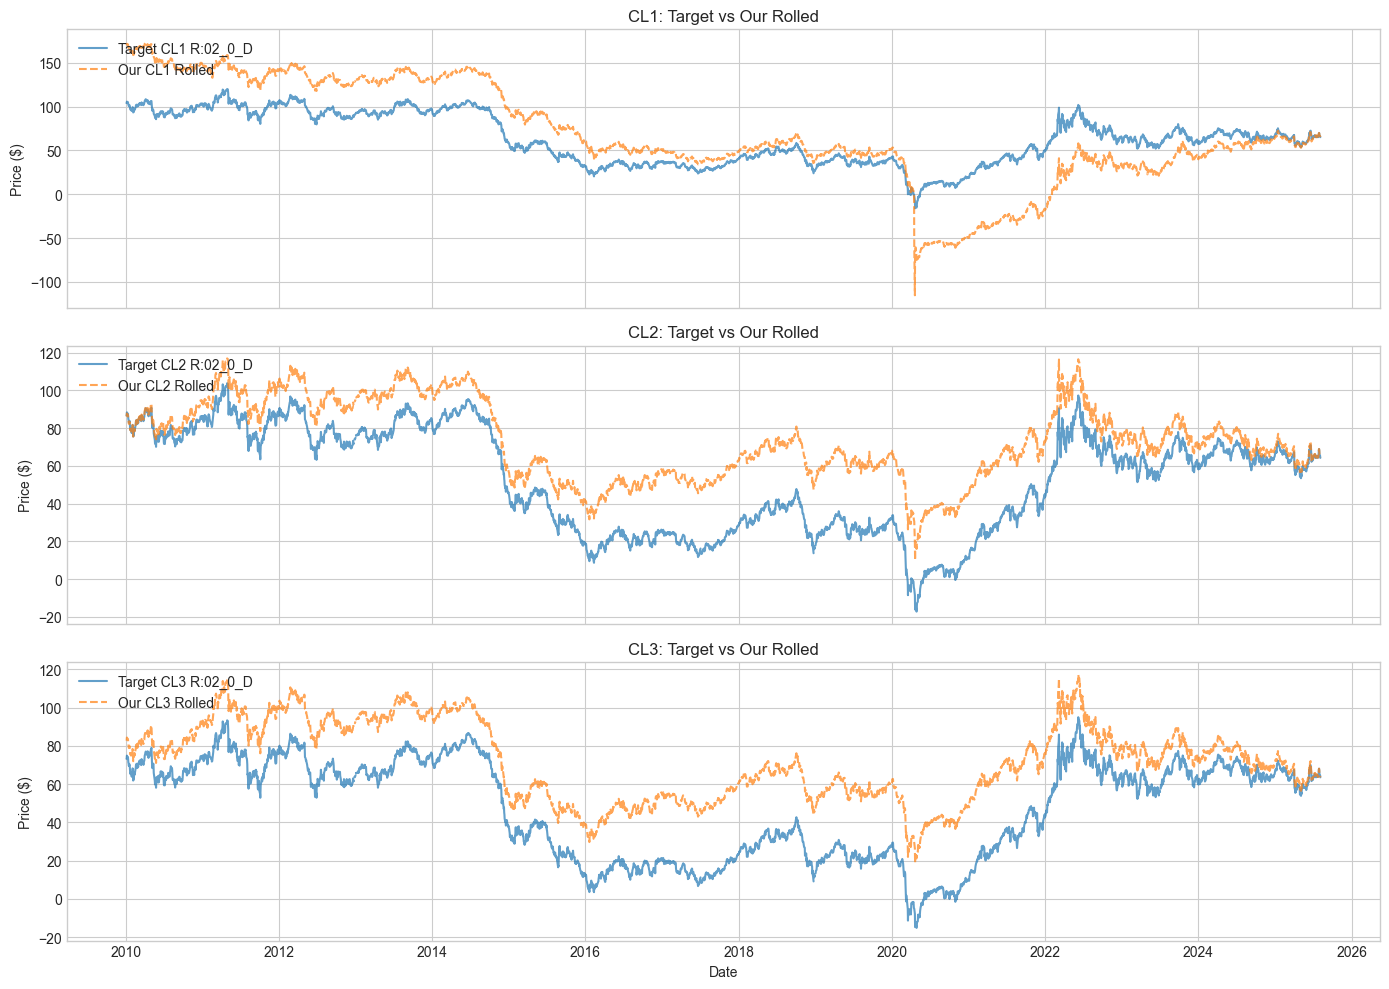

In [15]:
# Compare all contracts
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, (contract, target_col) in enumerate(zip(['CL1', 'CL2', 'CL3'], rolled_cols)):
    ax = axes[i]
    ax.plot(df.index, df[target_col], label=f'Target {target_col}', alpha=0.7)
    ax.plot(df.index, rolled_all[f'{contract}_rolled'], label=f'Our {contract} Rolled', 
            alpha=0.7, linestyle='--')
    ax.set_ylabel('Price ($)')
    ax.set_title(f'{contract}: Target vs Our Rolled')
    ax.legend(loc='upper left')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

---

## 6. Validation Metrics

Compute detailed validation metrics for each contract.

In [16]:
def compute_validation_metrics(
    target: pd.Series,
    predicted: pd.Series
) -> dict:
    """
    Compute validation metrics between target and predicted series.
    """
    diff = predicted - target
    abs_diff = diff.abs()
    
    # Compute returns for correlation
    target_ret = target.pct_change().dropna()
    pred_ret = predicted.pct_change().dropna()
    
    return {
        'mean_diff': diff.mean(),
        'std_diff': diff.std(),
        'mean_abs_diff': abs_diff.mean(),
        'max_abs_diff': abs_diff.max(),
        'price_correlation': target.corr(predicted),
        'return_correlation': target_ret.corr(pred_ret),
        'mape': (abs_diff / target.abs()).mean() * 100  # Mean Absolute Percentage Error
    }


# Compute metrics for each contract
metrics_list = []
for contract, target_col in zip(['CL1', 'CL2', 'CL3'], rolled_cols):
    metrics = compute_validation_metrics(
        df[target_col],
        rolled_all[f'{contract}_rolled']
    )
    metrics['contract'] = contract
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list).set_index('contract')
print("Validation Metrics:")
metrics_df.round(4)

Validation Metrics:


/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_15728/2916996224.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  target_ret = target.pct_change().dropna()
/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_15728/2916996224.py:13: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pred_ret = predicted.pct_change().dropna()


,mean_diff,std_diff,mean_abs_diff,max_abs_diff,price_correlation,return_correlation,mape
contract,,,,,,,
CL1,5.9633,37.1014,31.8212,108.14,0.8385,-0.0059,173.1506
CL2,20.5672,10.7461,20.5713,35.98,0.9384,0.0778,122.7451
CL3,24.4920,10.0965,24.4920,38.50,0.9326,-0.0200,233.7253


---

## 7. Export Results

In [17]:
# Create final output DataFrame
output_df = df[raw_cols + rolled_cols].copy()

# Add our rolled prices
for contract in ['CL1', 'CL2', 'CL3']:
    output_df[f'{contract}_rolled_reproduced'] = rolled_all[f'{contract}_rolled']

# Save to CSV (optional)
# output_df.to_csv('wti_rolled_prices_reproduced.csv')

print("Output DataFrame columns:")
for col in output_df.columns:
    print(f"  - {col}")

output_df.head(10)

Output DataFrame columns:
  - CL1
  - CL2
  - CL3
  - CL1 R:02_0_D
  - CL2 R:02_0_D
  - CL3 R:02_0_D
  - CL1_rolled_reproduced
  - CL2_rolled_reproduced
  - CL3_rolled_reproduced


,CL1,CL2,CL3,CL1 R:02_0_D,CL2 R:02_0_D,CL3 R:02_0_D,CL1_rolled_reproduced,CL2_rolled_reproduced,CL3_rolled_reproduced
2010-01-04,81.51,82.12,82.65,104.06,86.72,73.20,169.98,86.09,82.65
2010-01-05,81.77,82.41,82.99,104.32,87.01,73.54,170.24,86.38,82.99
2010-01-06,83.18,83.75,84.31,105.73,88.35,74.86,171.65,87.72,84.31
2010-01-07,82.66,83.19,83.75,105.21,87.79,74.30,171.13,87.16,83.75
2010-01-08,82.75,83.30,83.87,105.30,87.90,74.42,171.22,87.27,83.87
2010-01-11,82.52,83.01,83.55,105.07,87.61,74.10,170.99,86.98,83.55
2010-01-12,80.79,81.17,81.70,103.34,85.77,72.25,169.26,85.14,81.70
2010-01-13,79.65,80.04,80.60,102.20,84.64,71.15,168.12,84.01,80.60
2010-01-14,79.39,79.88,80.47,101.94,84.48,71.02,167.86,83.85,80.47
2010-01-15,78.00,78.37,78.97,100.55,82.97,69.52,166.47,82.34,78.97


---

## Summary

This notebook implements a modular `FuturesRoller` class that:

1. **Detects roll dates** by identifying when the front contract price jumps toward the second contract
2. **Computes adjustments** using the backward (Panama) method by default
3. **Applies cumulative adjustments** to create a continuous price series

### Key Parameters (R:02_0_D)
- Roll occurs 2 days before contract expiry
- Backward adjustment method (Panama)
- Daily frequency

### Future Improvements
- Add volume-based roll detection (roll when back month volume exceeds front)
- Support for explicit roll date calendars
- Add more adjustment methods (proportional, etc.)
- Handle holidays and weekends more explicitly